Below lines are only for downloading dataset and checking resources.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!wget --keep-session-cookies --save-cookies=cookies.txt --post-data 'username=avilaJorge&password=C323781C&submit=Login' https://www.cityscapes-dataset.com/login/
!wget --load-cookies cookies.txt --content-disposition https://www.cityscapes-dataset.com/file-handling/?packageID=1

In [0]:
!wget --keep-session-cookies --save-cookies=cookies.txt --post-data 'username=avilaJorge&password=C323781C&submit=Login' https://www.cityscapes-dataset.com/login/
!wget --load-cookies cookies.txt --content-disposition https://www.cityscapes-dataset.com/file-handling/?packageID=3

In [0]:
import zipfile
with zipfile.ZipFile('leftImg8bit_trainvaltest.zip', 'r') as zip_ref:
    zip_ref.extractall('./Data')
with zipfile.ZipFile('gtFine_trainvaltest.zip', 'r') as zip_ref:
    zip_ref.extractall('./Data')

In [0]:
# !cp -nR ./datasets/. ./drive/My\ Drive/CSE253/datasets
!mv ./Data ./cityscapes
!mkdir datasets
!mv ./cityscapes ./datasets/cityscapes
!rm ./leftImg8bit_trainvaltest.zip
!rm ./gtFine_trainvaltest.zip

In [0]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')


Fri Feb 14 11:15:13 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    31W / 250W |   8027MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

------------- Code Starts Here -----------

In [0]:
from torchvision import utils
from dataloader import *
from utils import *
import torchvision
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
from torch.autograd import Variable
import torch
import time
from datetime import datetime

In [0]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [0]:
class FCN_bak(torch.nn.Module):

    def __init__(self, n_class):
        super(FCN_bak, self).__init__()
        self.n_class = n_class
        self.conv1   = nn.Conv2d(3, 32, kernel_size=(3,5), stride=(2,4), padding=1, dilation=1)
        self.bnd1    = nn.BatchNorm2d(32)
        self.conv2   = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1, dilation=1)
        self.bnd2    = nn.BatchNorm2d(64)
        self.conv3   = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, dilation=1)
        self.bnd3    = nn.BatchNorm2d(128)
        self.conv4   = nn.Conv2d(128,256, kernel_size=3, stride=2, padding=1, dilation=1)
        self.bnd4    = nn.BatchNorm2d(256)
        self.conv5   = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1, dilation=1)
        self.bnd5    = nn.BatchNorm2d(512)
        self.relu    = nn.ReLU(inplace=True)
        
        self.deconv1 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn1     = nn.BatchNorm2d(256)
        self.deconv2 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn2     = nn.BatchNorm2d(128)
        self.deconv3 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn3     = nn.BatchNorm2d(64)
        self.deconv4 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn4     = nn.BatchNorm2d(32)
        self.deconv5  = nn.ConvTranspose2d(32, 3, kernel_size=(3, 5), stride=(2,4), padding=1, dilation=1, output_padding=1)
        self.bn5= nn.BatchNorm2d(3)
        self.classifier = nn.Conv2d(3,n_class, kernel_size=1, stride=1, padding=0, dilation=1)
        
    def forward(self, x):
        pool = nn.MaxPool2d(2, stride=2,return_indices = True)
        unpool = nn.MaxUnpool2d(2, stride=2)
        
        x1, indice1 = pool(self.relu(self.conv1(x)))
        x2, indice2 = pool(self.relu(self.conv2(self.bnd1(x1))))
        x3, indice3 = pool(self.relu(self.conv3(self.bnd2(x2))))
        x4, indice4 = pool(self.relu(self.conv4(self.bnd3(x3))))
        x5, indice5 = pool(self.relu(self.conv5(self.bnd4(x4))))
        
        z1 = self.deconv1(self.bnd5(self.relu(unpool((x5), indice5))))
        z2 = self.deconv2(self.bn1(self.relu(unpool((z1), indice4))))
        z3 = self.deconv3(self.bn2(self.relu(unpool((z2), indice3))))
        z4 = self.deconv4(self.bn3(self.relu(unpool((z3), indice2))))
        z5 = self.deconv5(self.bn4(self.relu(unpool((z4), indice1))))
        
        out_decoder = self.classifier(self.bn5(z5))                  

        return out_decoder  # size=(N, n_class, x.H/1, x.W/1)

In [0]:
class AverageBase(object):
    
    def __init__(self, value=0):
        self.value = float(value) if value is not None else None
       
    def __str__(self):
        return str(round(self.value, 4))
    
    def __repr__(self):
        return self.value
    
    def __format__(self, fmt):
        return self.value.__format__(fmt)
    
    def __float__(self):
        return self.value
    

class RunningAverage(AverageBase):
    """
    Keeps track of a cumulative moving average (CMA).
    """
    
    def __init__(self, value=0, count=0):
        super(RunningAverage, self).__init__(value)
        self.count = count
        
    def update(self, value):
        self.value = (self.value * self.count + float(value))
        self.count += 1
        self.value /= self.count
        return self.value


class MovingAverage(AverageBase):
    """
    An exponentially decaying moving average (EMA).
    """
    
    def __init__(self, alpha=0.99):
        super(MovingAverage, self).__init__(None)
        self.alpha = alpha
        
    def update(self, value):
        if self.value is None:
            self.value = float(value)
        else:
            self.value = self.alpha * self.value + (1 - self.alpha) * float(value)
        return self.value

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
def print_GPU_stats():
    print("total GPU Mem: ", torch.cuda.get_device_properties(device).total_memory)
    print("total GPU Cached: ", torch.cuda.memory_cached(device))
    print("total GPU Allocated: ", torch.cuda.memory_allocated(device))
    print("Available GB: ", (torch.cuda.get_device_properties(device).total_memory - torch.cuda.memory_allocated(device))/(10**9))
print_GPU_stats()

cuda:0
total GPU Mem:  17071734784
total GPU Cached:  0
total GPU Allocated:  0
Available GB:  17.071734784


In [1]:
batch_size = 7
num_wrkrs = 2
train_dataset = CityScapesDataset(csv_file='train_local.csv')
val_dataset = CityScapesDataset(csv_file='val_local.csv')
test_dataset = CityScapesDataset(csv_file='test_local.csv')
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          num_workers=num_wrkrs,
                          shuffle=True)
val_loader = DataLoader(dataset=val_dataset,
                          batch_size=batch_size,
                          num_workers=num_wrkrs,
                          shuffle=True)
test_loader = DataLoader(dataset=test_dataset,
                          batch_size=batch_size,
                          num_workers=num_wrkrs,
                          shuffle=False)

NameError: ignored

torch.Size([7, 3, 1024, 2048])
torch.Size([7, 3, 8, 512, 512])


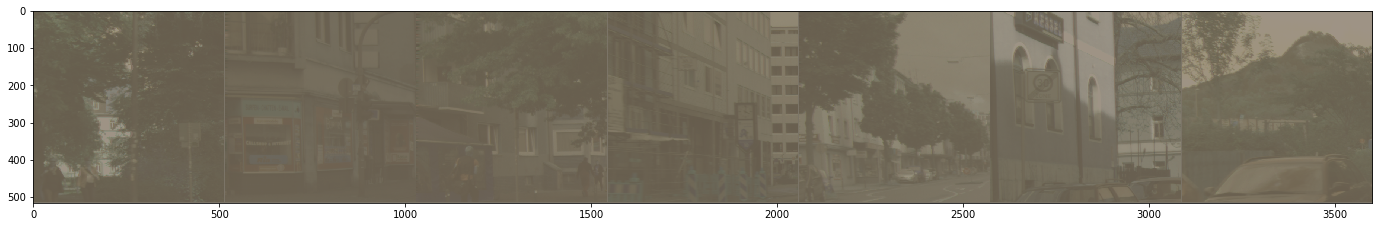

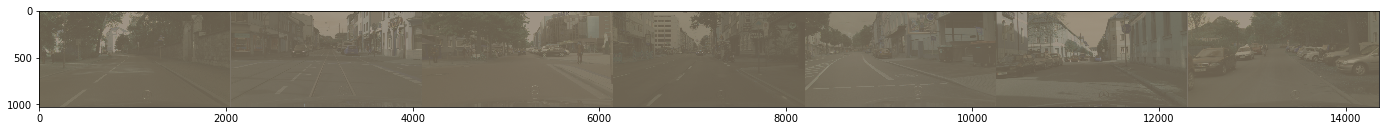

In [0]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(24,10))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, _, classes = next(iter(train_loader))
print(inputs.size())
kernel_size = 512
kernel_stride = 512
a = inputs.unfold(2, kernel_size, kernel_stride).unfold(3, kernel_size, kernel_stride)
a = a.contiguous().view(a.size(0), a.size(1), -1, a.size(4), a.size(5))
print(a.shape)

# Make a grid from batch
out = torchvision.utils.make_grid(a[:,:,0])

imshow(out, title="")

out = torchvision.utils.make_grid(inputs)
imshow(out)

In [0]:
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.xavier_uniform_(m.weight.data)
        m.bias.data.zero_()

epochs     = 100
start_epoch = 1
path = '/content/drive/My Drive/CSE253/PA3/Base_LR00005/'
criterion = torch.nn.CrossEntropyLoss()
fcn_model = FCN_bak(n_class=34)
# fcn_model.apply(init_weights)
# fcn_model.load_state_dict(torch.load(path + 'model_02_13_08_47.pt'))
optimizer = optim.Adam(fcn_model.parameters(), lr=5e-5, weight_decay=1e-3)

In [0]:
dt = datetime.now().strftime("%m_%d_%H_%M")
output_fn = path + "model_output_" + dt + ".txt"
best_model_fn = path + "best_model_" + dt + ".pt"
model_fn = path + "model_" + dt + ".pt"

def print_info(out_str):
    f = open(output_fn,"a")
    print(out_str)
    f.write(out_str)
    f.close()

# print_info("Started: %s\nFrom a previously trained model which left off on start of epoch 9.\n" % datetime.now())
print_info("Started: %s\n" % datetime.now())

Started: 2020-02-14 11:16:11.088845



In [0]:
use_gpu = torch.cuda.is_available()
# use_gpu = False
if use_gpu:
    fcn_model = fcn_model.to(device)
    
best_loss = float('inf')
prev_loss = float('inf')
loss_inc_cnt = 0
stop_early = False

def train():
    softmax = nn.Softmax(dim=1)
    print("Starting Training")

    for epoch in range(start_epoch, epochs):
        trn_losses = MovingAverage()
        trn_accs = MovingAverage()
        trn_ious = MovingAverage()
        ts = time.time()
        for iter, (X, tar, Y) in enumerate(train_loader):
            optimizer.zero_grad()

            if use_gpu:
                inputs = X.to(device)
                labels_cat = Y.to(device)
            else:
                inputs, labels_cat, labels_enc = X, Y, tar
            
            outputs = softmax(fcn_model(inputs))
            loss = criterion(outputs, labels_cat)
            loss.backward()
            optimizer.step()
            loss = loss.item()

            output_labels = outputs.argmax(dim=1)

            trn_losses.update(loss)
            trn_accs.update(pixel_acc(output_labels, labels_cat))
            trn_ious.update(np.nanmean(iou(output_labels, labels_cat)))
            
            if iter % 10 == 0:
                print_info("epoch{}, iter{}, loss: {} \n".format(epoch, iter, loss))
                
        
        print_info("Finish epoch {}, time elapsed {} \n".format(epoch, time.time() - ts))
    
        loss, acc, IoU = trn_losses.value, trn_accs.value, trn_ious.value 

        print_info("Training Check:\tLoss: %f\tAccuracy: %f\tIoU: %f \n" % (loss, acc * 100, IoU))
        
        val(epoch)
        if stop_early: return

def evaluate(data_loader, validation=False, verbose=False):

    global best_loss
    global prev_loss
    global loss_inc_cnt
    global stop_early
    
    with torch.no_grad():
        losses = RunningAverage()
        accs = RunningAverage()
        ious = RunningAverage()
        softmax = nn.Softmax(dim=1)
        ts = time.time()
        print("Starting Evaluation")
        
        for iter, (X, tar, Y) in enumerate(data_loader):

            if use_gpu:
                inputs = X.to(device)
                labels_cat = Y.to(device)
            else:
                inputs, labels_cat, labels_enc = X, Y, tar

            outputs = softmax(fcn_model(inputs))

            output_labels = outputs.argmax(dim=1)

            losses.update(criterion(outputs, labels_cat).item())

            accs.update(pixel_acc(output_labels, labels_cat))

            ious.update(np.nanmean(iou(output_labels, labels_cat)))

        print("Finished evaluation. Time elapsed %f" % (time.time() - ts))

        # This probably should not be a straight average, but just doing this for now
        loss = losses.value 
        acc = accs.value 
        IoU = ious.value 
        
        if validation:
            if best_loss > loss:
                best_loss = loss
                print_info("Best Loss: " + str(best_loss) + "\n")
                torch.save(fcn_model.state_dict(), best_model_fn)
            loss_inc_cnt = loss_inc_cnt + 1 if prev_loss < loss else 0
            if loss_inc_cnt > 3: stop_early = True
            torch.save(fcn_model.state_dict(), model_fn)
        
        return loss, acc, IoU

def val(epoch):
    # fcn_model.eval()
    # Complete this function - Calculate loss, accuracy and IoU for every epoch
    # Make sure to include a softmax after the output from your model
    loss, acc, IoU = evaluate(val_loader, validation=True)
    print_info("Validation Results: Loss: %f\tAccuracy: %f\tIoU: %f \n" % (loss, acc * 100, IoU))
    if stop_early: print_info("Epoch %d:\tStopping Early" % (epoch))
    
def test():
    print(' ')
    # Complete this function - Calculate accuracy and IoU 
    # Make sure to include a softmax after the output from your model
    loss, acc, IoU = evaluate(test_loader)
    print_info("Test Results:\tLoss: %f\tAccuracy: %f\tIoU: %f \n" % (loss, acc * 100, IoU))
    
if __name__ == "__main__":
    val(0)  # show the accuracy before training
    print_info("---------Above is accuracy before training.---------\n")
    train()
    test()

Streaming output truncated to the last 5000 lines.
epoch47, iter240, loss: 3.02177095413208 

epoch47, iter250, loss: 2.9713776111602783 

epoch47, iter260, loss: 3.069326400756836 

epoch47, iter270, loss: 2.9793262481689453 

epoch47, iter280, loss: 2.986750841140747 

epoch47, iter290, loss: 2.985954999923706 

epoch47, iter300, loss: 3.015117883682251 

epoch47, iter310, loss: 3.0228374004364014 

epoch47, iter320, loss: 2.9862542152404785 

epoch47, iter330, loss: 2.9584386348724365 

epoch47, iter340, loss: 2.996378183364868 

epoch47, iter350, loss: 3.0303633213043213 

epoch47, iter360, loss: 3.0508358478546143 

epoch47, iter370, loss: 2.9934468269348145 

epoch47, iter380, loss: 2.999415159225464 

epoch47, iter390, loss: 3.0054149627685547 

epoch47, iter400, loss: 2.962421417236328 

epoch47, iter410, loss: 2.996687173843384 

epoch47, iter420, loss: 2.9853360652923584 

Finish epoch 47, time elapsed 326.42858242988586 

Training Check:	Loss: 2.984317	Accuracy: 62.390429	Io